In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os

In [2]:
from sklearn.utils import shuffle
import random
import matplotlib.image as mpimg
import json

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [4]:
root_dir = 'C:/Users/user/New folder7/casting/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

In [5]:
test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

In [6]:
train_path = root_dir + 'train/'
test_path = root_dir + 'test/'

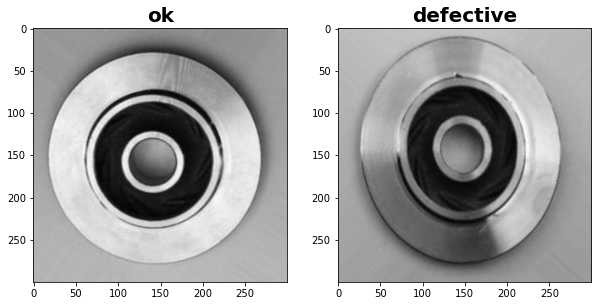

In [7]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

de = plt.imread(train_path + 'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.title("defective", weight='bold', size=20)
plt.imshow(de,cmap='gray')

plt.show()

In [11]:
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

In [12]:
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)


Found 6633 images belonging to 2 classes.


In [13]:
test_set = image_gen.flow_from_directory(test_path,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 715 images belonging to 2 classes.


In [11]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding = 'same', strides = (1,1),input_shape=image_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', strides = (1,1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


# Third Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same', strides = (1,1)))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

In [12]:
#Compilation of the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# callback and model saving
model_save_path = 'casting_product_detection.hdf5'
early_stop = EarlyStopping(monitor='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [14]:
history= model.fit(train_set, epochs=5, validation_data=test_set, callbacks=[early_stop,checkpoint])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.6906
Epoch 00001: val_loss improved from inf to 0.36794, saving model to casting_product_detection.hdf5
208/208 [==============================] - 724s 3s/step - loss: 0.5617 - accuracy: 0.6906 - val_loss: 0.3679 - val_accuracy: 0.8629
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8544
Epoch 00002: val_loss improved from 0.36794 to 0.22284, saving model to casting_product_detection.hdf5
208/208 [==============================] - 882s 4s/step - loss: 0.3264 - accuracy: 0.8544 - val_loss: 0.2228 - val_accuracy: 0.9161
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9157
Epoch 00003: val_loss improved from 0.22284 to 0.13655, saving model to casting_product_detection.hdf5
208/208 [==============================] - 619s 3s/step - loss: 0.2087 - accuracy: 0.9157 - val_loss: 0.1366 - val_accuracy: 0.9483
Epoch 4/5
208/

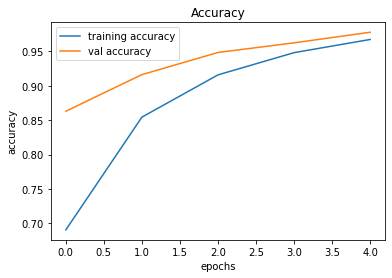

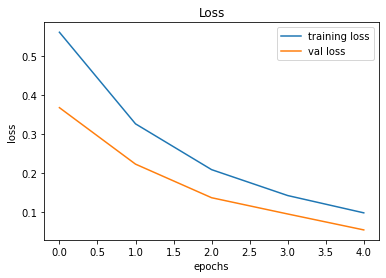

In [18]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
          

In [8]:
model = load_model("C:/Users/user/New folder7/casting/casting_product_detection.hdf5")

model_history = json.load(open('C:/Users/user/New folder7/casting/model_history.json', 'r'))

In [14]:
y_pred_prob = model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

23/23 [==============================] - 69s 3s/step


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

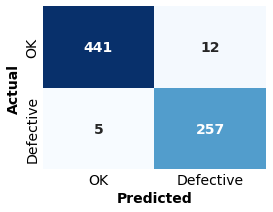

In [20]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [19]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9888    0.9735    0.9811       453
           1     0.9554    0.9809    0.9680       262

    accuracy                         0.9762       715
   macro avg     0.9721    0.9772    0.9745       715
weighted avg     0.9766    0.9762    0.9763       715



An overall classification accuracy of 97.66% is achieved by the trained model which means that, 
out of 715 test images, there are 17 cases of misclassification

In [21]:
# prediction with test data

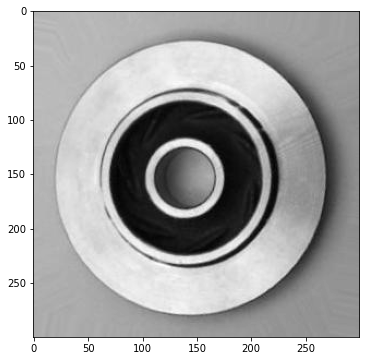

In [23]:
img = cv2.imread(test_path+'ok_front/cast_ok_0_1020.jpeg',0)
img = img/255 #rescalinng
pred_img =img.copy()

plt.figure(figsize=(12,6))
plt.imshow(img,cmap='gray')

ok_front


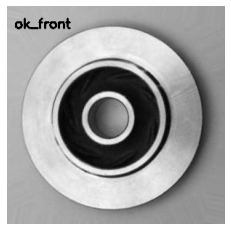

In [19]:
prediction = model.predict(img.reshape(-1,300,300,1))
if (prediction<0.5):
    print("def_front")
    cv2.putText(pred_img, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img,cmap='gray')
plt.axis('off')
plt.show()

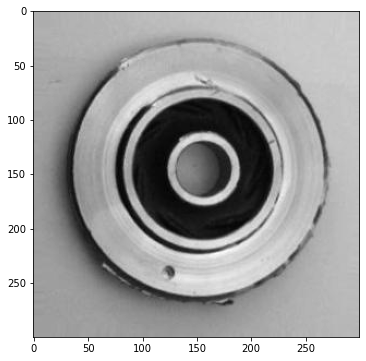

In [24]:
img = cv2.imread(test_path+'def_front/cast_def_0_160.jpeg',0)
img = img/255 #rescalinng

pred_img =img.copy()
plt.figure(figsize=(12,6))
plt.imshow(img,cmap='gray')

def_front


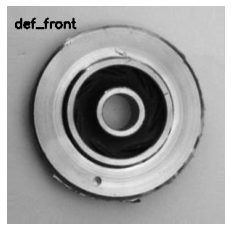

In [25]:
prediction = model.predict(img.reshape(-1,300,300,1))
if (prediction<0.5):
    print("def_front")
    cv2.putText(pred_img, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img,cmap='gray')
plt.axis('off')
plt.show()

# conclusion

A convolutional neural networks model was created to classify images of a casting product.
Results of this project suggest viability of deep learning method in automating visual inspection. 
